In [ ]:
!wget https://huggingface.co/danjacobellis/dance/resolve/main/LF_rgb_f16c12_v1.6.pth

In [1]:
import torch
import torch.nn as nn
import PIL.Image
import io
import numpy as np
import datasets
import time
from types import SimpleNamespace
from datasets import Dataset
from torchvision.transforms.v2 import CenterCrop
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent
from piq import LPIPS, DISTS, SSIMLoss

In [2]:
device = "cpu"
valid_dataset = datasets.load_dataset("danjacobellis/kodak", split='validation')

In [3]:
checkpoint = torch.load('LF_rgb_f16c12_v1.6.pth', map_location=device,weights_only=False)
config = checkpoint['config']
state_dict = checkpoint['state_dict']

model = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J=int(config.F**0.5),
    latent_dim=config.latent_dim,
    lightweight_encode=config.lightweight_encode,
    lightweight_decode=config.lightweight_decode,
    post_filter=config.post_filter
).to(device)
model.load_state_dict(state_dict)
model.eval();

8.614 KB
136.94543765962388x compression ratio
64.0x dimension reduction
22.89040238825521 dB PSNR


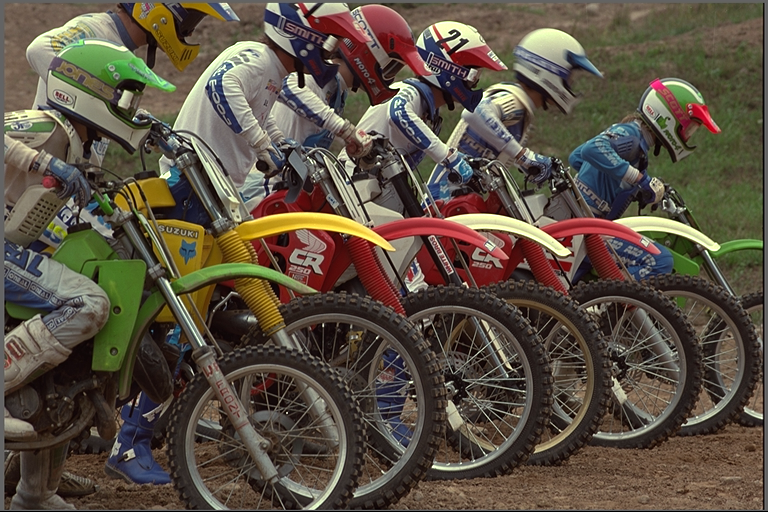

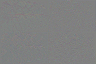

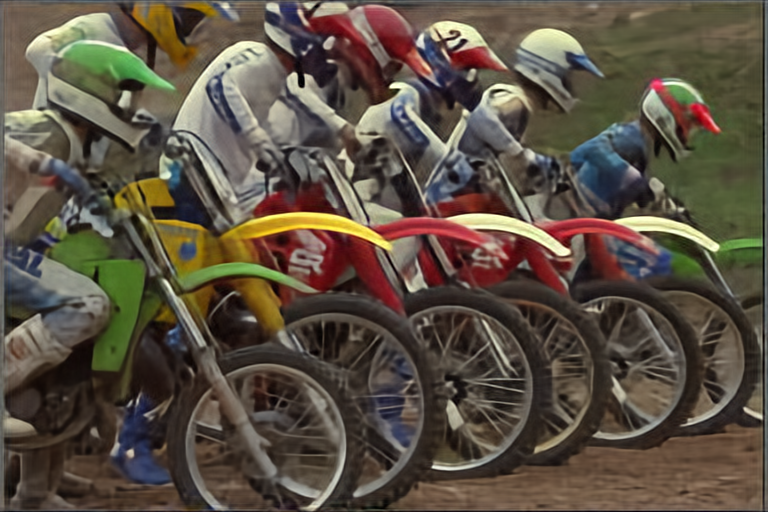

In [8]:
img = valid_dataset[4]['image']
x = pil_to_tensor(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()

webp = latent_to_pil(latent.cpu(), n_bits=8, C=3)
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")

latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)

with torch.no_grad():
    x_hat = model.decode(latent_decoded)
    if config.post_filter:
        x_hat = model.post_filter(x_hat)

mse = torch.nn.functional.mse_loss(x_orig, x_hat[0])
PSNR = -10 * mse.log10().item() + 20*np.log10(2)
print(f"{PSNR} dB PSNR")

display(to_pil_image(x_orig.clamp(-1, 1) / 2 + 0.5))
display(webp[0]) 
display(to_pil_image(x_hat[0].clamp(-1, 1) / 2 + 0.5))

9.904 KB
119.10823909531503x compression ratio
22.83696937561035 PSNR


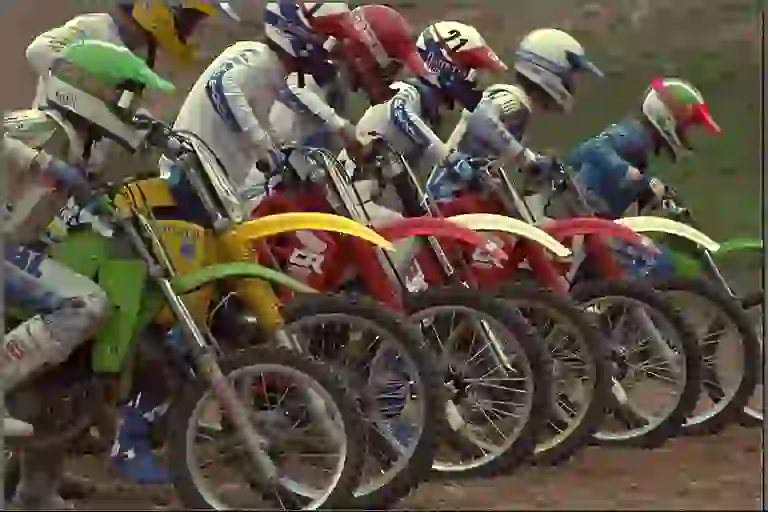

In [10]:
buff = io.BytesIO()
img.save(buff, format='WEBP', quality=0)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
buff.seek(0)
webp = PIL.Image.open(buff)
MSE = torch.nn.functional.mse_loss(pil_to_tensor(webp).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
display(webp)

In [13]:
def compress_and_evaluate(sample, quality=0.1):
    img = sample['image']
    x_orig = pil_to_tensor(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0  # Normalize to [-1, 1]
    orig_dim = x_orig.numel()  # Number of elements (width * height * channels)

    # --- Neural Codec ---
    # Encode
    t0 = time.time()
    with torch.no_grad():
        z = model.encode(x_orig)
        latent = model.quantize.compand(z).round()
    neural_encode_time = time.time() - t0

    # Save latent as WebP lossless
    webp = latent_to_pil(latent.cpu(), n_bits=8, C=3)
    buff = io.BytesIO()
    webp[0].save(buff, format='WEBP', lossless=True)
    neural_size_bytes = len(buff.getbuffer())

    # Decode
    t0 = time.time()
    latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)
    with torch.no_grad():
        x_hat = model.decode(latent_decoded)
        if config.post_filter:
            x_hat=model.post_filter(x_hat)
    x_hat = x_hat.clamp(-1,1)
    neural_decode_time = time.time() - t0
    neural_bpp = 8 * neural_size_bytes / (img.width * img.height)

    # --- WebP ---
    # Encode
    t0 = time.time()
    buff = io.BytesIO()
    img.save(buff, format='WEBP', quality=quality)
    webp_size_bytes = len(buff.getbuffer())
    webp_encode_time = time.time() - t0

    # Decode
    t0 = time.time()
    buff.seek(0)
    webp_img = PIL.Image.open(buff)
    webp_decode_time = time.time() - t0
    webp_bpp = 8 * webp_size_bytes / (img.width * img.height)

    # Return dictionary of metrics
    return {
        'neural_size_bytes': neural_size_bytes,
        'neural_bpp': neural_bpp,
        'neural_encode_time': neural_encode_time,
        'neural_decode_time': neural_decode_time,
        'webp_size_bytes': webp_size_bytes,
        'webp_bpp': webp_bpp,
        'webp_encode_time': webp_encode_time,
        'webp_decode_time': webp_decode_time,
    }

metrics = [
    'neural_bpp',
    'neural_encode_time',
    'neural_decode_time',
    'webp_bpp',
    'webp_encode_time',
    'webp_decode_time',
]

In [14]:
results_dataset = valid_dataset.map(lambda batch: compress_and_evaluate(batch,0.45))

print("mean\n---")
for metric in metrics:
    μ = np.mean(results_dataset[metric])
    print(f"{metric}: {μ}")

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

mean
---
neural_bpp: 0.1477508544921875
neural_encode_time: 2.134146918853124
neural_decode_time: 15.100159446398417
webp_bpp: 0.14813062879774305
webp_encode_time: 0.1190755267937978
webp_decode_time: 0.0017787714799245198


In [15]:
results_dataset = valid_dataset.map(lambda batch: compress_and_evaluate(batch,1.4))

print("median\n---")
for metric in metrics:
    μ = np.median(results_dataset[metric])
    print(f"{metric}: {μ}")

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

median
---
neural_bpp: 0.14664713541666669
neural_encode_time: 2.0993800163269043
neural_decode_time: 15.140567302703857
webp_bpp: 0.14912923177083334
webp_encode_time: 0.12084853649139404
webp_decode_time: 0.0017589330673217773
